## HitBoost for Survival Analysis

### Introduction
`HitBoost` is a method of survival analysis that predicts P.D.F. of F.H.T. (First Hitting Time) via a Multi-output Gradient Boosting Decision Tree. More details can refer to [the paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8700177&isnumber=6514899).

Here we show you how to use `HitBoost` model to predict FHT from scratch with the help of `libsurv`.

### Preparation

For all things going well, you would be better to get acquainted with **Survival Analysis**. Otherwise, I suggest you read the [reference](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html).

And it may help a lot if you know a little of the classical FHT model.

### Get it started

#### Load datasets

We provide `WHAS` and `METABRIC` datasets for further studies. It can be found in module `libsurv.datasets`.

In [1]:
from libsurv.datasets import load_whas_train
from libsurv.datasets import load_whas_test

data_train = load_whas_train()
data_test = load_whas_test()

In [2]:
print(data_train.columns)

Index(['age', 'gender', 'bmi', 'chf', 'miord', 'e', 't'], dtype='object')


#### Statistics of datasets
Print statistics of survival data. The function `survival_stats` in `libsurv.datasets` provides the tool.

--------------- Survival Data Statistics ---------------
# Rows: 1310
# Columns: 5 + e + t
# Events Ratio: 42.14%
# Min Time: 1
# Max Time: 67



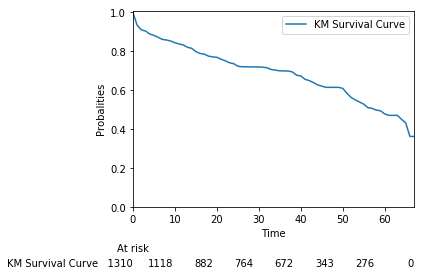

In [3]:
from libsurv.datasets import survival_stats

survival_stats(data_train, t_col="t", e_col="e", plot=True)

--------------- Survival Data Statistics ---------------
# Rows: 328
# Columns: 5 + e + t
# Events Ratio: 42.07%
# Min Time: 1
# Max Time: 67



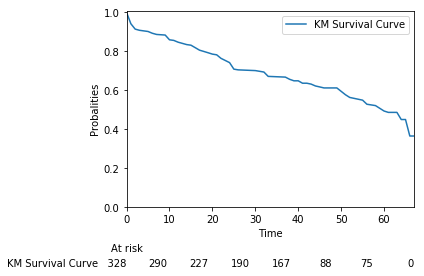

In [4]:
survival_stats(data_test, t_col="t", e_col="e", plot=True)

#### Survival data transfrom

The column of time and status in survival data will be packed into an new column as label in the transformed data.

The transformed survival data contains an new label, where negtive values are considered as right censored, and positive values are considered as event occurrence.

**NOTE**: In `libsurv`, survival data must be transformed via `libsurv.datasets.survival_df`. But for `xgboost` model, the type of data must be `DMatrix`, so we **have two ways to achive this as listed below**.

```python
##############################################################################
# method 1:
from libsurv.datasets import survival_dmat

surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

##############################################################################

##############################################################################
# method 2
from libsurv.datasets import survival_df
from xgboost import DMatrix


data_train = survival_df(data_train, t_col="t", e_col="e", label_col="Y")
data_test = survival_df(data_test, t_col="t", e_col="e", label_col="Y")

x_cols = list(data_train.columns)[:-1]

surv_train = DMatrix(data_train[x_cols], label=data_train['Y'].values)
surv_test = DMatrix(data_test[x_cols], label=data_test['Y'].values)
################################################################################
```

In [5]:
from libsurv.datasets import survival_dmat

# via survival_dmat function
surv_train = survival_dmat(data_train, t_col="t", e_col="e", label_col="Y")
surv_test = survival_dmat(data_test, t_col="t", e_col="e", label_col="Y")

#### Model initialization

Here we start to initialize a HitBoost model.

**NOTE**: `num_class` in `model_params` is equals to **K + 1**, where **K denotes the maximum observed time** in your survival data. And `'objective': 'multi:softprob'` is required in `model_params`.

In [6]:
from libsurv import HitBoost

# the arguments can be obtained by Bayesian Hyperparameters Tuning
model_params = {
    'eta': 0.1,
    'max_depth': 6, 
    'min_child_weight': 0.28816386304629,
    'subsample': 0.6,
    'colsample_bytree': 0.5,
    'gamma': 0.07046659244693994,
    'lambda': 0.01324648983388066,
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 67+1,
    'seed': 42
}

model = HitBoost(model_params, loss_alpha=0.6, loss_gamma=0.01)

#### Model training

Training model and plotting the learning curve.

# After 10th iteration:
	On train:
		Loss: 1.16408
		td-CI: 0.83766
	On test:
		Loss: 1.27578
		td-CI: 0.754783
# After 20th iteration:
	On train:
		Loss: 0.858955
		td-CI: 0.889963
	On test:
		Loss: 1.02646
		td-CI: 0.791129
# After 30th iteration:
	On train:
		Loss: 0.656503
		td-CI: 0.923862
	On test:
		Loss: 0.853256
		td-CI: 0.812314
# After 40th iteration:
	On train:
		Loss: 0.503436
		td-CI: 0.946284
	On test:
		Loss: 0.719528
		td-CI: 0.836476
# After 50th iteration:
	On train:
		Loss: 0.397893
		td-CI: 0.958563
	On test:
		Loss: 0.633119
		td-CI: 0.847736
# After 60th iteration:
	On train:
		Loss: 0.322763
		td-CI: 0.967107
	On test:
		Loss: 0.56654
		td-CI: 0.859475
# After 70th iteration:
	On train:
		Loss: 0.274064
		td-CI: 0.974458
	On test:
		Loss: 0.530281
		td-CI: 0.874328
# After 80th iteration:
	On train:
		Loss: 0.243882
		td-CI: 0.977808
	On test:
		Loss: 0.504348
		td-CI: 0.885588
# After 90th iteration:
	On train:
		Loss: 0.225171
		td-CI: 0.981231
	On test:
		Los

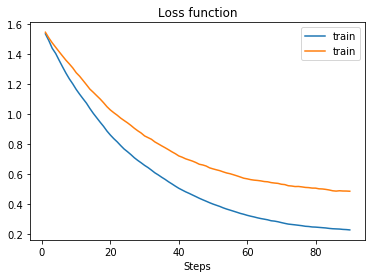

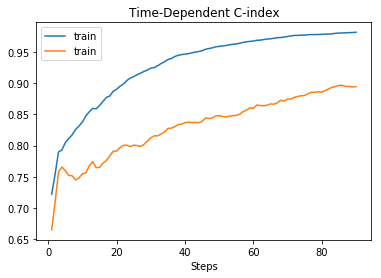

In [7]:
eval_result = model.train(
    surv_train,
    num_rounds=90,
    skip_rounds=10,
    evals=[(surv_train, 'train'), (surv_test, 'test')],
    silent=False,
    plot=True
)

#### Prediction and Evaluation

Now we use the trained model to make prediction or evaluate model performance.

Give the prediction of HitBoost model with:
- `model.predict`: P.D.F of FHT
- `model.predict_survival_function`: survival function transformed from P.D.F of FHT

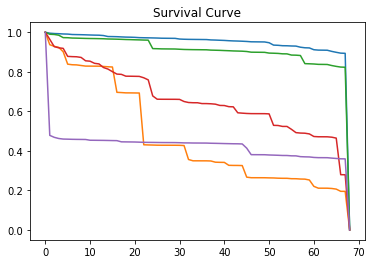

In [8]:
# make prediction and plot the estimated P.D.F. of F.H.T.

# select the first 5 samples
surv_data_now = surv_test.slice([i for i in range(5)])

result_survf = model.predict_survival_function(surv_data_now, plot=True)

In [9]:
# evaluate model performance 
print("td-CI on training set:", model.evals(surv_train))
print("td-CI on test set:", model.evals(surv_test))

td-CI on training set: 0.981231321752461
td-CI on test set: 0.8943495670625278


#### Factor improtance

Get the factor importance score evaluated by the model.

It's suggested that you **repeat obtaining the factor score for multiply times**, such as 20, by specifing a different random seed in `model_params`. 

Parameter `importance_type`: str. The metrics of importance evaluation. see more in [https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_score].

The function returns a dict.

In [10]:
fscore = model.get_factor_score(importance_type='weight')

# normalize the scores
sum_score = sum(fscore.values())
fscore = {k: v / sum_score for k, v in fscore.items()}
print(fscore)

{'bmi': 0.4125874125874126, 'miord': 0.0745024206562668, 'age': 0.3604760623991393, 'chf': 0.07793168370091447, 'gender': 0.0745024206562668}


#### save model

In [11]:
model.save_model("HitBoost.model")